# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
from make_plots import *
from kerasAC.splits import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 1

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

effect_scores = {}

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores[fold] = get_hyp_scores(effect_file, effect_seqs)
    effect_scores[fold] = np.array(effect_scores[fold])
    merged_effect_scores = merged_effect_scores + effect_scores[fold]
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

noneffect_scores = {}

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores[fold] = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores[fold] = np.array(noneffect_scores[fold])
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores[fold]
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 642
Num noneffect sequences: 	 642
Num scores: 	 	 	 642


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []
motif_others = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_other = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
                motif_other = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
            motif_other = noneffect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_other = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
                motif_other = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
            motif_other = effect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    motif_others.append(motif_other)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.48249476830591603
Median KS-test p-value: 	 0.47937192633515535
St. Dev KS-test p-value: 	 0.30468958313712674
Max KS-test p-value: 	 	 0.9984327839591955
Min KS-test p-value: 	 	 3.32852294344769e-17
Num significant p-values: 	 25

Mean non-zero motif length: 	 8.646103896103897
Median non-zero motif length: 	 9.0
St. Dev non-zero motif length: 	 5.6153655310943345
Max non-zero motif length: 	 26
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.685358255451714
Median motif length: 	 	 10.0
St. Dev motif length: 	 	 2.3441906711387728
Max motif length: 	 	 26
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps['motif_other'] = motif_others
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))


Number of Unique SNPs: 567


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 567


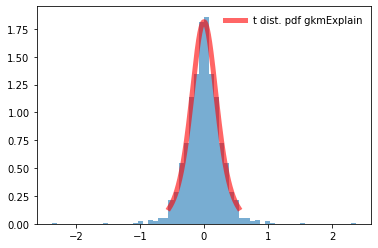

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 4.755945215095725
Mean: 	 2.015347729209978e-08
Stdev: 	 0.20857726439856653

KstestResult(statistic=0.012470995745232138, pvalue=0.9945305286988525)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 275


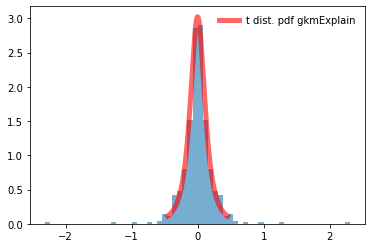

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 2.288791569572736
Mean: 	 -9.803481812183021e-07
Stdev: 	 0.11858870554611903

KstestResult(statistic=0.030593948503351953, pvalue=0.6819541344715498)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 275


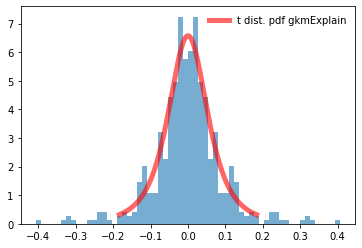

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 2.826011624965383
Mean: 	 -2.5870218677945856e-07
Stdev: 	 0.055612021443103996

KstestResult(statistic=0.018232949286218436, pvalue=0.9931179961345521)


## Distribution of ISM Scores

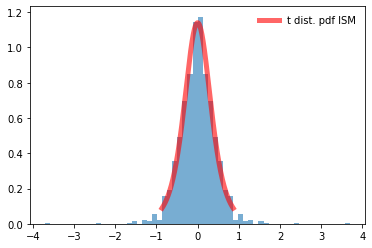

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 4.800680659425492
Mean: 	 -3.9910571639632725e-07
Stdev: 	 0.33221421462038037

KstestResult(statistic=0.012544113454303452, pvalue=0.9941018118114404)


## Distribution of Delta Scores

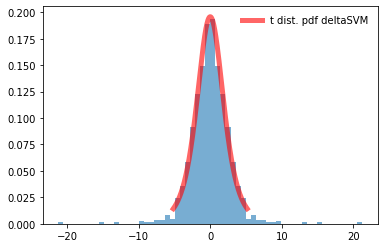

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 4.3656483788463545
Mean: 	 -3.892022988560351e-08
Stdev: 	 1.9254215177273404

KstestResult(statistic=0.010268846974225865, pvalue=0.9997603118892079)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.5445470420795873
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.45325582707171524
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.09261318301869043
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.18330932003286035
Negative ISM Cutoff: 	 	 	 	 	 -0.8647597436290775
Negative deltaSVM Cutoff: 	 	 	 	 -5.173792296997465

Total SNPs with Negative Scores: 	 	 	 5
Confident SNPs with Negative Scores: 	 	 	 3
Highly Confident SNPs with Negative Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
59,chr11,86103987,86103988,rs1237999,A,G,G,A,A,G,+,16,-0.059826,1.259066,0.015436,0.422143,-1.504711,-1.233548,-0.406707,-2.344655,-13.414169,Alzheimers_Jansen_2018,7.143148e-16,False,False,TATGAGTCACC,TATAAGTCACC,0.000983,0.005644,0.006443,0.001043,0.001603,0.451165,2
418,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,-0.310284,0.310145,0.000000,0.262735,-1.053658,-0.310145,-0.262735,-1.675440,-9.611985,Alzheimers_Jansen_2018,1.215671e-04,True,True,CGCCTCC,CCCCTCC,0.004517,0.104881,0.020522,0.004431,0.005977,0.392926,2
429,chr2,95323523,95323524,rs3755519,T,A,A,"C,G,T",T,"A,C,G",+,85,0.054939,0.532876,0.062505,0.173242,-0.837879,-0.371419,-0.110737,-1.318928,-7.596817,Nalls_23andMe,7.682450e-03,False,True,AGTGCTCTCTG,TGTGCTCTCTG,0.011237,0.074495,0.146132,0.011536,0.014240,0.467074,1
485,chr3,52237762,52237763,rs146527642,G,C,G,C,G,C,-,93,0.000000,0.000000,0.000000,0.000000,-0.679752,0.000000,0.000000,-1.055241,-6.186780,Chang_23andMe_Parkinsons,9.369830e-04,False,True,CCCACGCCCC,CCCAGGCCCC,0.024168,0.999994,0.999997,0.026073,0.028679,0.773235,0
3,chr1,161185601,161185602,rs4575098,A,G,G,A,G,A,+,12,0.000000,0.000000,0.000000,0.000000,-0.598793,0.000000,0.000000,-0.931719,-5.352862,Alzheimers_Jansen_2018,2.051494e-10,True,True,AAATGTTAAT,AAATATTAAT,0.037054,0.999994,0.999997,0.039539,0.045172,0.405842,0



Positive Original gkmExplain Cutoff: 	 	 	 0.5445470823865418
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.45325386637535253
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.0926126656143169
Positive Ratio Difference gkmExplain High Cutoff: 	 0.18330880262848673
Positive ISM Cutoff: 	 	 	 	 	 0.8647589454176444
Positive deltaSVM Cutoff: 	 	 	 	 5.173792219157005

Total SNPs with Positive Scores: 	 	 	 14
Confident SNPs with Positive Scores: 	 	 	 9
Highly Confident SNPs with Positive Scores: 	 	 6


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
270,chr17,45959712,45959713,rs113793114,G,A,G,A,G,A,+,54,0.504112,0.005524,0.400250,0.079537,0.691103,0.448133,0.320713,1.092992,6.309519,23andme_PD_hg38,2.581860e-22,True,False,CAAGGAGGCGGA,CAAGGAGGCAGA,0.022807,0.051176,0.012188,0.023059,0.026893,0.083073,2
222,chr17,45852666,45852667,rs62054825,G,A,G,A,G,A,+,54,1.037582,0.276194,0.403708,0.157385,0.806529,0.759603,0.246323,1.262465,7.246744,23andme_PD_hg38,1.247000e-22,True,True,CTCCCGGAAGTGGAG,CTCCCAGAAGTGGAG,0.012988,0.016625,0.024203,0.013624,0.016814,0.095736,2
240,chr17,45896863,45896864,rs62056782,T,C,C,T,C,T,-,54,1.468377,0.534259,0.567573,0.328514,0.968207,0.934118,0.239059,1.511886,8.711674,23andme_PD_hg38,3.938570e-22,True,True,CGCCCTCTTGTG,CGCCCTCCTGTG,0.006371,0.010522,0.026110,0.006743,0.008656,0.663296,2
41,chr11,60251676,60251677,rs636317,C,T,C,T,T,C,-,11,3.572579,1.266331,0.711414,0.477112,2.374887,2.306248,0.234302,3.694154,21.288201,Alzheimers_Kunkle_2019,5.906000e-15,False,False,TGCTGCCATCTGCTGGGAA,TGCTGCTATCTGCTGGGAA,0.000125,0.001365,0.027467,0.000131,0.000235,0.005708,2
294,chr17,46038519,46038520,rs12150090,T,C,C,"G,T",C,"G,T",-,54,0.539022,-0.115386,0.236528,0.008618,0.836860,0.524768,0.227910,1.307331,7.565130,23andme_PD_hg38,2.508350e-22,True,True,CCAATCCCACA,CCAACCCCACA,0.011289,0.036882,0.029440,0.011933,0.014453,0.905032,2
459,chr2,134719288,134719289,rs62171396,T,C,C,T,C,T,-,78,0.604211,0.088289,0.318015,0.092759,0.619902,0.476032,0.225257,0.991544,5.740914,Nalls_23andMe,1.039870e-02,False,True,CGGCTCTGGCAGAG,CGGCCCTGGCAGAG,0.033070,0.045200,0.030314,0.032229,0.036425,0.879104,2
494,chr3,52498433,52498434,rs181391313,G,A,G,A,G,A,-,93,0.238884,-0.108485,0.136971,0.000000,0.763101,0.238884,0.136971,1.193326,6.885841,Chang_23andMe_Parkinsons,2.730650e-03,False,True,GGGCGGAGGC,GGGCAGAGGC,0.015963,0.165228,0.095864,0.016803,0.020059,0.898236,1
18,chr10,80493944,80493945,rs7900536,A,C,C,"A,T",A,"C,T",+,5,1.575865,1.006411,0.570171,0.475175,0.655807,0.563832,0.094996,1.020218,6.073102,Alzheimers_Kunkle_2019,2.913000e-05,True,True,CCTCTAGAGGGATGATTCA,CCTCTAGAGGGATGATTCC,0.027355,0.031685,0.191728,0.029275,0.030456,0.058496,1
275,chr17,45966011,45966012,rs62063291,T,C,T,C,T,C,+,54,0.098052,-0.174494,0.092810,0.000000,0.741990,0.098052,0.092810,1.158995,6.636227,23andme_PD_hg38,2.301370e-22,True,False,CCAAGCTCCC,CCAAGCCCCC,0.017688,0.485619,0.199298,0.018695,0.022735,0.105911,1
21,chr10,102245652,102245653,rs2296887,T,C,T,C,T,C,-,1,0.194353,-0.059999,0.069580,0.000634,0.687793,0.192890,0.068946,1.070656,6.168091,Nalls_23andMe,6.977320e-03,False,True,ACAGGCTCCT,ACAGGCCCCT,0.023194,0.229567,0.308049,0.024791,0.028962,0.749727,0


In [25]:
def plot_seq_importance(tracks,labels, ylim,xlim=None, figsize=(25, 6),snp_pos=0, cluster=0, rsid='rs1234567'):
    num_plots=len(tracks)                                                       
    f,axes=plt.subplots(num_plots,dpi=80,figsize=figsize)                       
    show=False                                                                  
    tracks=[i.squeeze() for i in tracks]                                        
    seq_len = tracks[0].shape[0]                                                
    if xlim is None:                                                            
        xlim = (0, seq_len)                                                     
    for plot_index in range(num_plots):                                         
        cur_track=tracks[plot_index]                                            
        axes[plot_index]=plot_bases_on_ax(cur_track,axes[plot_index],show_ticks=True)
        axes[plot_index].set_xlim(xlim)                                         
        axes[plot_index].set_ylim(ylim)                                         
        cur_label=labels[plot_index]                                            
        axes[plot_index].set_title(':'.join([rsid,cluster,str(plot_index),'gkmSVM','gkmExplain',cur_label]))
        axes[plot_index].axvline(x=snp_pos,color='k',linestyle='--')            
        axes[plot_index].tick_params(                                           
            axis='x',          # changes apply to the x-axis                    
            which='both',      # both major and minor ticks are affected        
            bottom=False,      # ticks along the bottom edge are off            
            top=False,         # ticks along the top edge are off               
            labelbottom=False) # labels along the bottom edge are off           
    plt.subplots_adjust(hspace=0.8)                                             
    plt.savefig('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/svm_snp_tracks/png/cluster'+str(cluster)+'/'+rsid+'.png',dpi=120)
    #plt.savefig('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/svm_snp_tracks/svg/cluster'+str(cluster)+'/'+rsid+'_fold'+str(fold)+'.svg',dpi=120,format='svg')
    plt.close()                                                                 
    return

# Generate Test Fold Tracks

In [26]:
chr_to_fold = {}
for fold in hg19_splits:
    chroms = hg19_splits[fold]['test']
    for chrom in chroms:
        chr_to_fold[chrom] = fold
        
ylim_dict = {}

for index in neg_snps.index:
    #fold = chr_to_fold[neg_snps.at[index, 'chr']]
    all_merged = np.ones(shape=(1000, 4))
    for fold in range(10):
        diff = effect_scores[fold][index] - noneffect_scores[fold][index]
        all_merged = np.append(noneffect_scores[fold][index], effect_scores[fold][index], axis=0)
        all_merged = np.append(all_merged, diff, axis=0)
    ylim_dict[index] = (np.amin(np.array([min(i) for i in all_merged])),
                        np.amax(np.array([max(i) for i in all_merged])))

for index in neg_snps.index:
    test_fold = chr_to_fold[neg_snps.at[index, 'chr']]
    
    plot_seq_importance([noneffect_scores[fold][index] for fold in range(10)]
                         + [effect_scores[fold][index] for fold in range(10)]
                         + [effect_scores[fold][index] - noneffect_scores[fold][index] for fold in range(10)],
                         #effect_scores[test_fold][index],
                         #effect_scores[test_fold][index] - noneffect_scores[test_fold][index]],
                       #labels=['non-effect', 'effect', 'effect - noneffect'],
                       labels = ['noneffect' for i in range(10)]
                                 + ['effect' for i in range(10)]
                                 + ['effect - noneffect' for i in range(10)],
                       xlim=(399,599),
                       ylim=ylim_dict[index],
                       figsize=(18, 90),
                       snp_pos=500,
                       cluster=cluster, rsid=neg_snps.at[index, 'rsid'])

# for index in pos_snps.index:
#     fold = chr_to_fold[pos_snps.at[index, 'chr']]
#     diff = effect_scores[fold][index] - noneffect_scores[fold][index]
#     all_merged = np.append(noneffect_scores[fold][index], effect_scores[fold][index], axis=0)
#     all_merged = np.append(all_merged, diff, axis=0)
#     ylim_dict[index] = (np.amin(np.array([min(i) for i in all_merged])),
#                         np.amax(np.array([max(i) for i in all_merged])))
    
# for index in pos_snps.index:
#     fold = chr_to_fold[pos_snps.at[index, 'chr']]
#     plot_seq_importance([noneffect_scores[fold][index],
#                          effect_scores[fold][index],
#                          effect_scores[fold][index] - noneffect_scores[fold][index]],
#                        labels=['non-effect', 'effect', 'effect - noneffect'],
#                        xlim=(399,599),
#                        ylim=ylim_dict[index],
#                        figsize=(18, 6),
#                        snp_pos=500,
#                        cluster=cluster, fold=str(fold), rsid=pos_snps.at[index, 'rsid'])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-2590d3a86b8e>", line 35, in <module>
    cluster=cluster, rsid=neg_snps.at[index, 'rsid'])
  File "<ipython-input-25-2fd727a75ab8>", line 24, in plot_seq_importance
    plt.savefig('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/svm_snp_tracks/png/cluster'+str(cluster)+'/'+rsid+'.png',dpi=120)
  File "/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/matplotlib/pyplot.py", line 723, in savefig
    fig.canvas.draw_idle()   # need this if 'transparent=True' to reset colors
  File "/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/matplotlib/backend_bases.py", line 1907, in draw_idle
    self.draw(*args, **kwargs)
  File "/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/matplotlib

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fee44c1e268> (for post_execute):


KeyboardInterrupt: 

# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 59

RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 16   ||    IDR Peak: False

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 7.1431E-16   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: G   ||   Noneffect Center: 1.2591   ||   Center / 200bp : 0.4221

Noneffect Motif: TATGAGTCACC


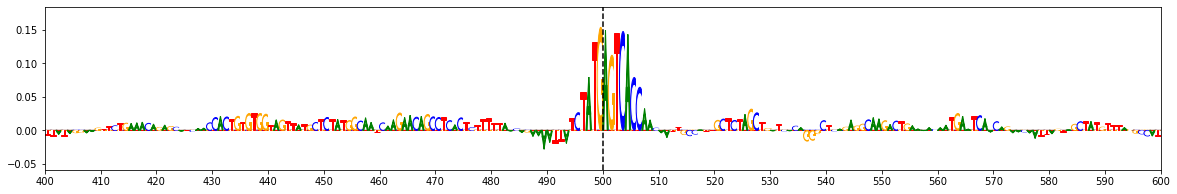

Effect Allele: A   ||   Effect Center: -0.0598   ||   Center / 200bp : 0.0154

Effect Motif: TATAAGTCACC


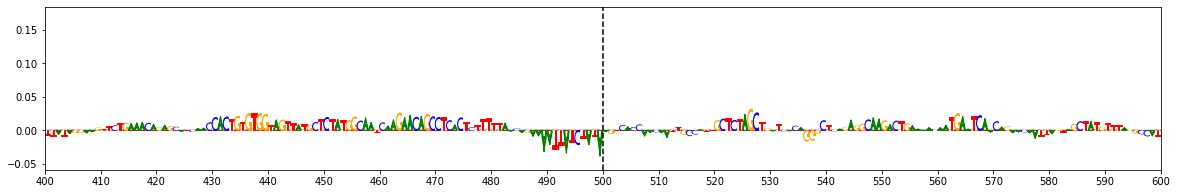

gkmExplain Score: -0.4067  ||  ISM Score: -2.3447  ||  deltaSVM Score: -13.4142

gkmExplain P-Value: 0.006443  ||  ISM P-Value: 0.001043  ||  deltaSVM P-Value: 0.001603

Difference Motif: TAT(G/A)AGTCACC


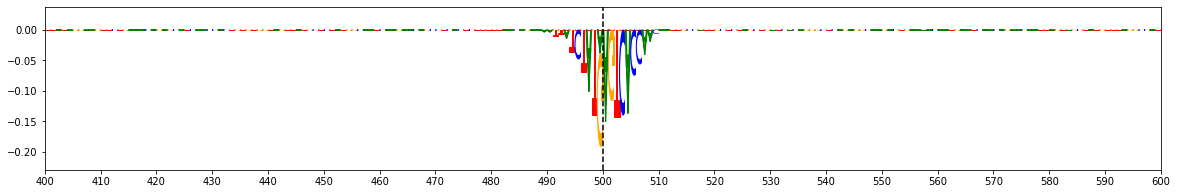



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 418

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.2157E-04   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: G   ||   Noneffect Center: 0.3101   ||   Center / 200bp : 0.2627

Noneffect Motif: CGCCTCC


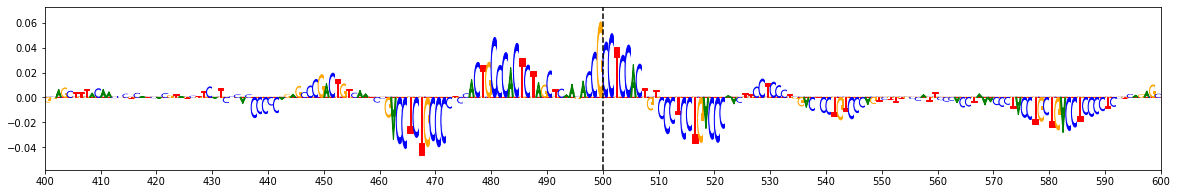

Effect Allele: C   ||   Effect Center: -0.3103   ||   Center / 200bp : 0.0

Effect Motif: CCCCTCC


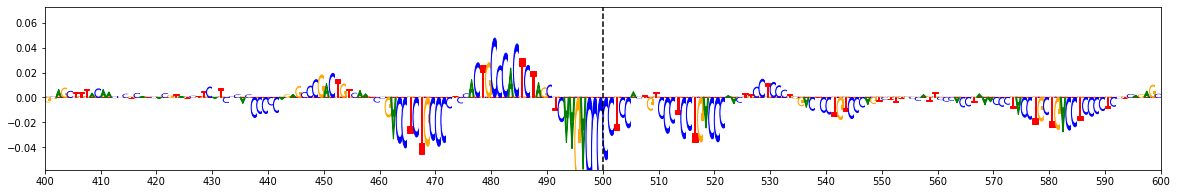

gkmExplain Score: -0.2627  ||  ISM Score: -1.6754  ||  deltaSVM Score: -9.612

gkmExplain P-Value: 0.020522  ||  ISM P-Value: 0.004431  ||  deltaSVM P-Value: 0.005977

Difference Motif: C(G/C)CCTCC


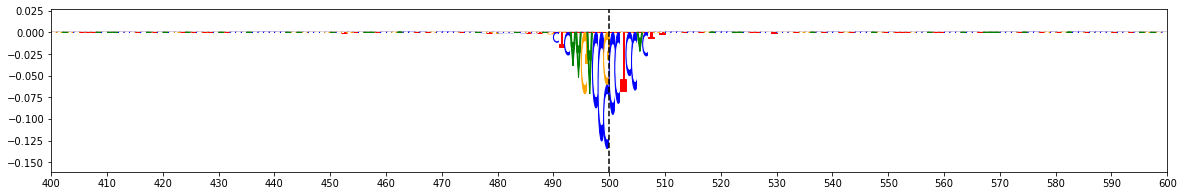



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 429

RSID: rs3755519   ||    chr2 : 95323523 - 95323524   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 7.6825E-03   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.5329   ||   Center / 200bp : 0.1732

Noneffect Motif: AGTGCTCTCTG


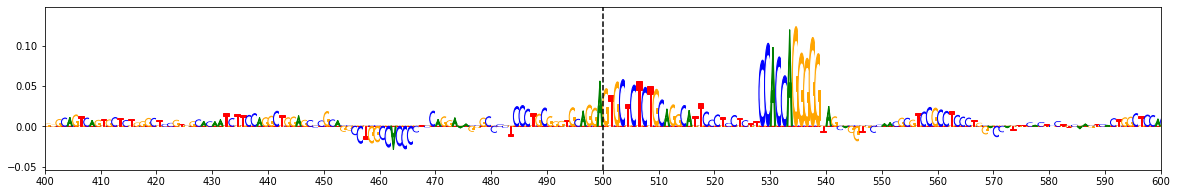

Effect Allele: T   ||   Effect Center: 0.0549   ||   Center / 200bp : 0.0625

Effect Motif: TGTGCTCTCTG


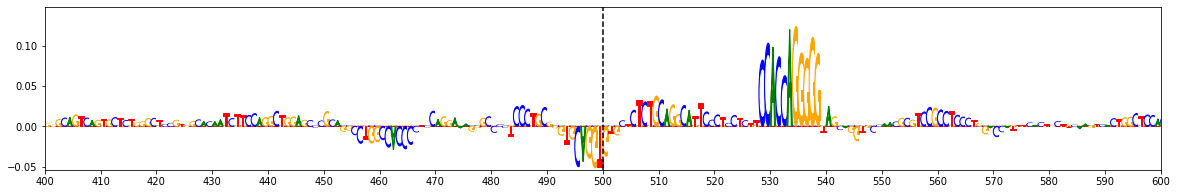

gkmExplain Score: -0.1107  ||  ISM Score: -1.3189  ||  deltaSVM Score: -7.5968

gkmExplain P-Value: 0.146132  ||  ISM P-Value: 0.011536  ||  deltaSVM P-Value: 0.01424

Difference Motif: (A/T)GTGCTCTCTG


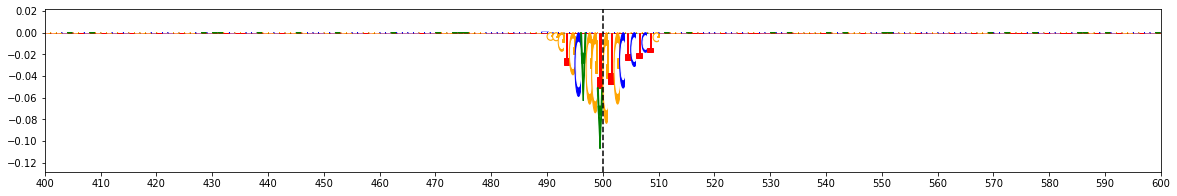



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 485

RSID: rs146527642   ||    chr3 : 52237762 - 52237763   ||    Locus: 93   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 9.3698E-04   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCACGCCCC


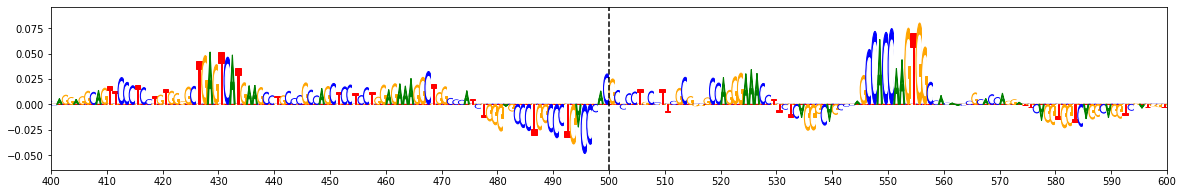

Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCAGGCCCC


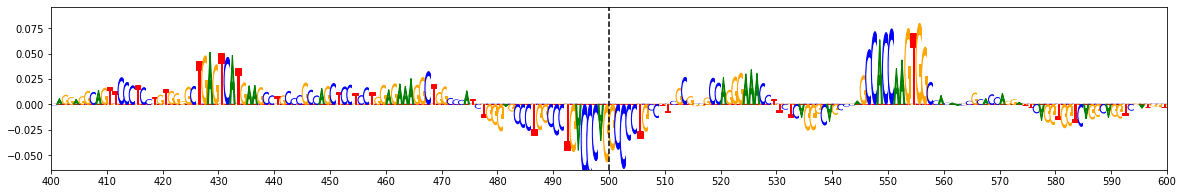

gkmExplain Score: 0.0  ||  ISM Score: -1.0552  ||  deltaSVM Score: -6.1868

gkmExplain P-Value: 0.999997  ||  ISM P-Value: 0.026073  ||  deltaSVM P-Value: 0.028679

Difference Motif: CCCA(C/G)GCCCC


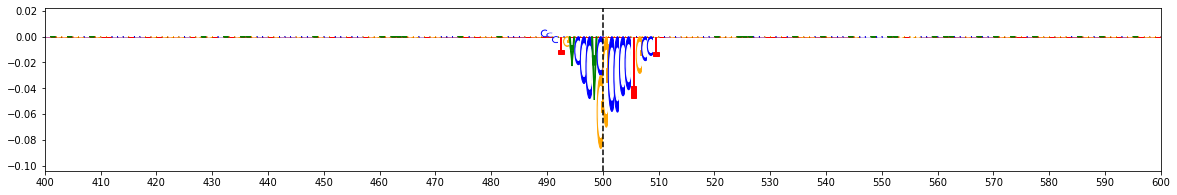



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 3

RSID: rs4575098   ||    chr1 : 161185601 - 161185602   ||    Locus: 12   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 2.0515E-10   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: AAATGTTAAT


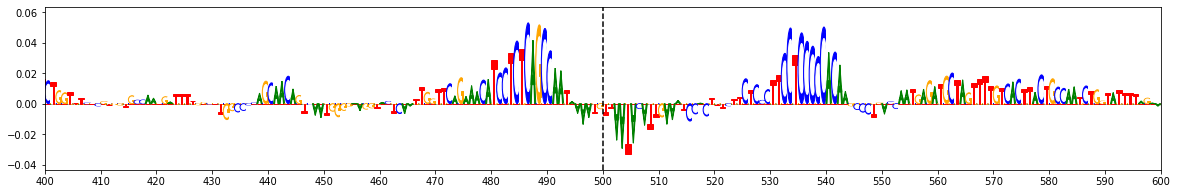

Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: AAATATTAAT


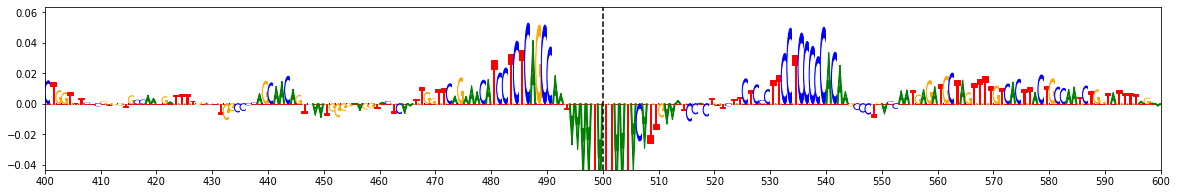

gkmExplain Score: 0.0  ||  ISM Score: -0.9317  ||  deltaSVM Score: -5.3529

gkmExplain P-Value: 0.999997  ||  ISM P-Value: 0.039539  ||  deltaSVM P-Value: 0.045172

Difference Motif: AAAT(G/A)TTAAT


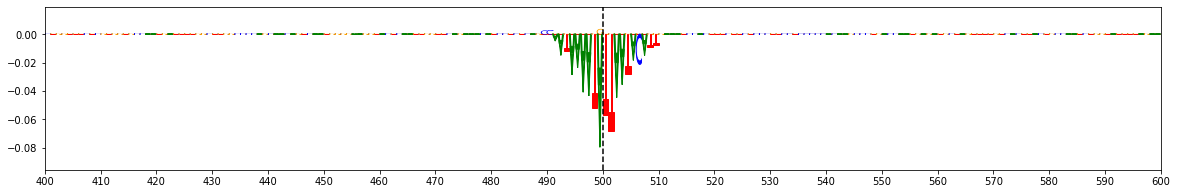



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif_other'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 270

RSID: rs113793114   ||    chr17 : 45959712 - 45959713   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 2.5819E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.5041   ||   Center / 200bp : 0.4003

Effect Motif: CAAGGAGGCGGA


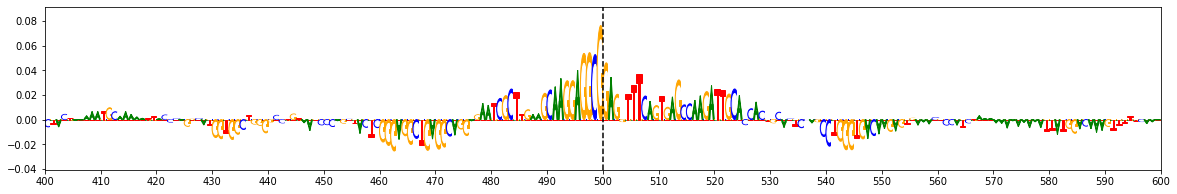

Noneffect Allele: A   ||   Noneffect Center: 0.0055   ||   Center / 200bp : 0.0795

Noneffect Motif: CAAGGAGGCAGA


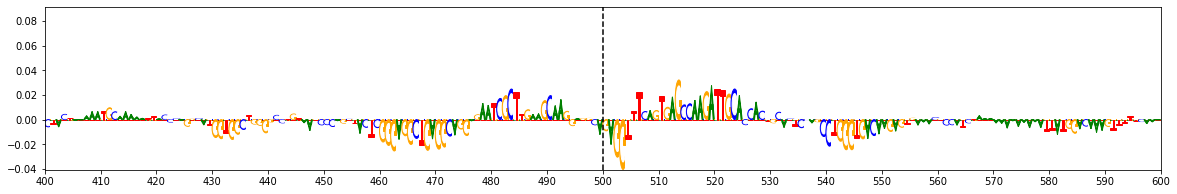

gkmExplain Score: 0.3207  ||  ISM Score: 1.093  ||  deltaSVM Score: 6.3095

gkmExplain P-Value: 0.012188  ||  ISM P-Value: 0.023059  ||  deltaSVM P-Value: 0.026893

Difference Motif: CAAGGAGGC(G/A)GA


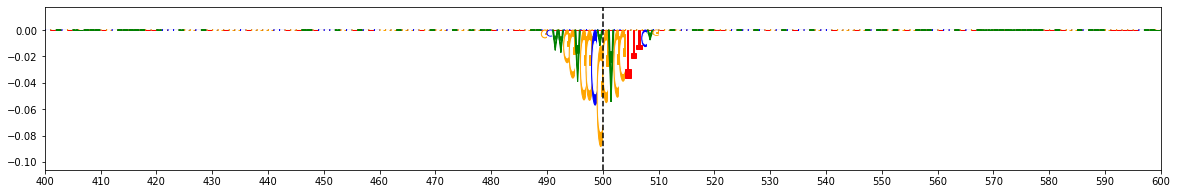



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 222

RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.2470E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 1.0376   ||   Center / 200bp : 0.4037

Effect Motif: CTCCCGGAAGTGGAG


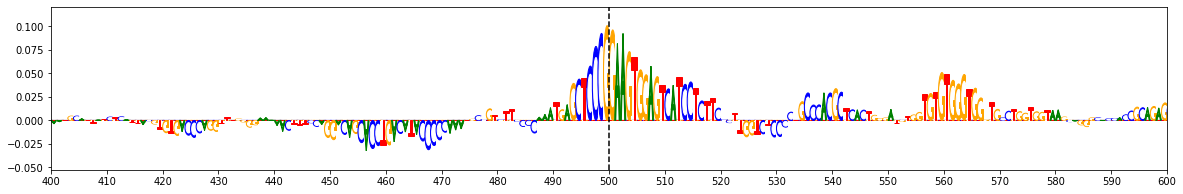

Noneffect Allele: A   ||   Noneffect Center: 0.2762   ||   Center / 200bp : 0.1574

Noneffect Motif: CTCCCAGAAGTGGAG


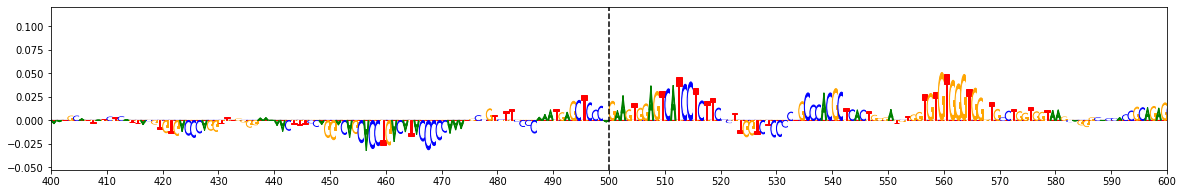

gkmExplain Score: 0.2463  ||  ISM Score: 1.2625  ||  deltaSVM Score: 7.2467

gkmExplain P-Value: 0.024203  ||  ISM P-Value: 0.013624  ||  deltaSVM P-Value: 0.016814

Difference Motif: CTCCC(G/A)GAAGTGGAG


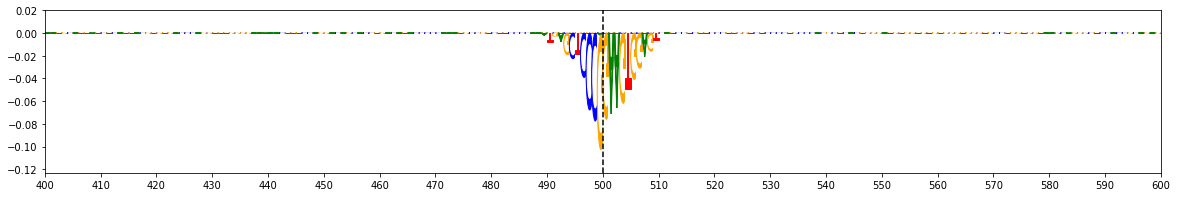



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 240

RSID: rs62056782   ||    chr17 : 45896863 - 45896864   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9386E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 1.4684   ||   Center / 200bp : 0.5676

Effect Motif: CGCCCTCTTGTG


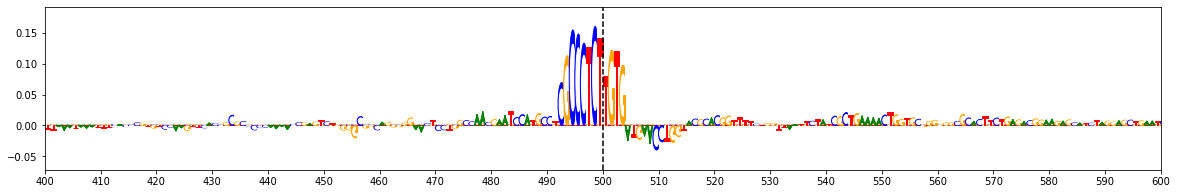

Noneffect Allele: C   ||   Noneffect Center: 0.5343   ||   Center / 200bp : 0.3285

Noneffect Motif: CGCCCTCCTGTG


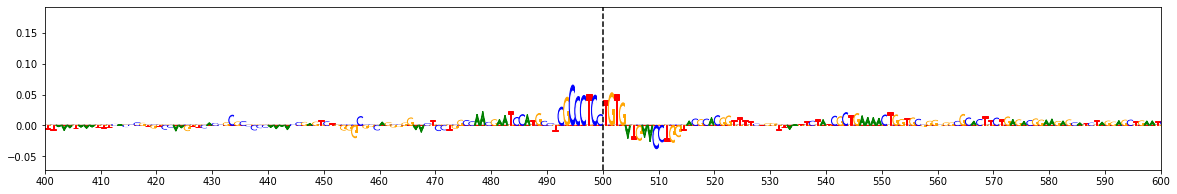

gkmExplain Score: 0.2391  ||  ISM Score: 1.5119  ||  deltaSVM Score: 8.7117

gkmExplain P-Value: 0.02611  ||  ISM P-Value: 0.006743  ||  deltaSVM P-Value: 0.008656

Difference Motif: CGCCCTC(T/C)TGTG


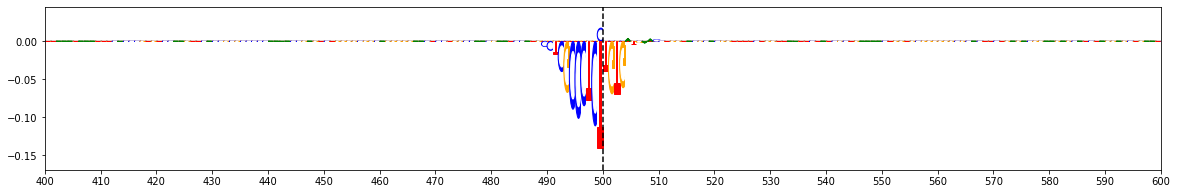



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 41

RSID: rs636317   ||    chr11 : 60251676 - 60251677   ||    Locus: 11   ||    IDR Peak: False

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 5.9060E-15   ||    Coloc: False   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 3.5726   ||   Center / 200bp : 0.7114

Effect Motif: TGCTGCCATCTGCTGGGAA


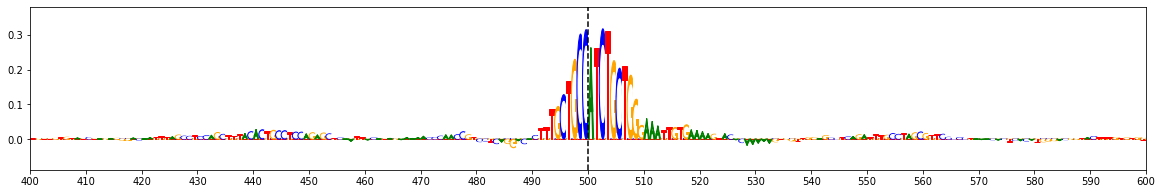

Noneffect Allele: T   ||   Noneffect Center: 1.2663   ||   Center / 200bp : 0.4771

Noneffect Motif: TGCTGCTATCTGCTGGGAA


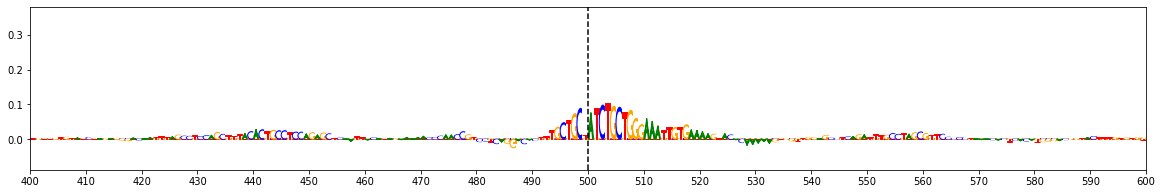

gkmExplain Score: 0.2343  ||  ISM Score: 3.6942  ||  deltaSVM Score: 21.2882

gkmExplain P-Value: 0.027467  ||  ISM P-Value: 0.000131  ||  deltaSVM P-Value: 0.000235

Difference Motif: TGCTGC(C/T)ATCTGCTGGGAA


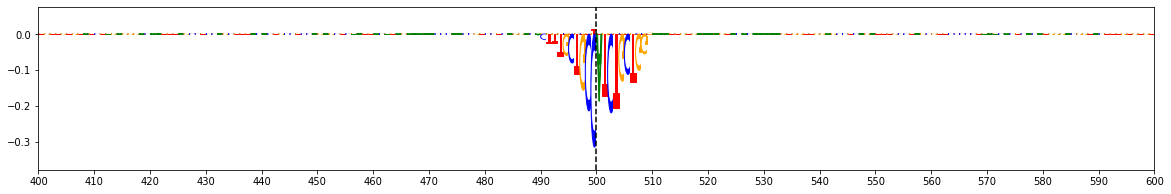



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 294

RSID: rs12150090   ||    chr17 : 46038519 - 46038520   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 2.5084E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 0.539   ||   Center / 200bp : 0.2365

Effect Motif: CCAATCCCACA


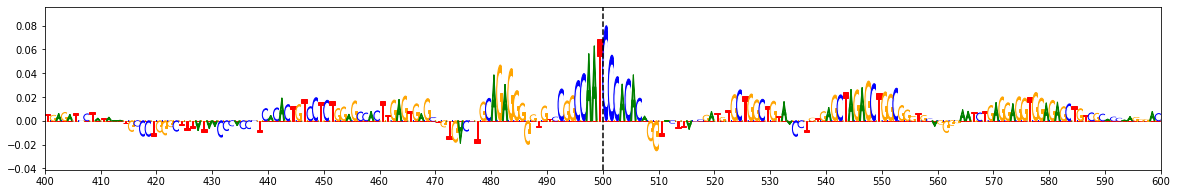

Noneffect Allele: C   ||   Noneffect Center: -0.1154   ||   Center / 200bp : 0.0086

Noneffect Motif: CCAACCCCACA


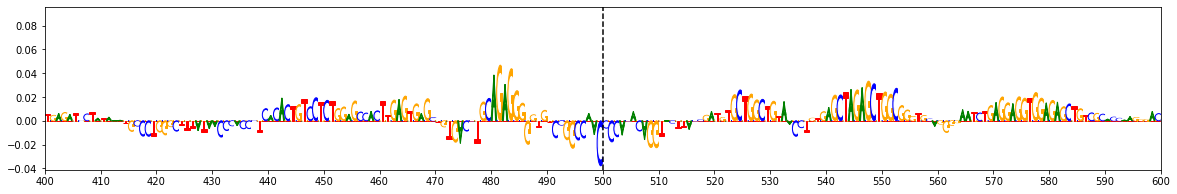

gkmExplain Score: 0.2279  ||  ISM Score: 1.3073  ||  deltaSVM Score: 7.5651

gkmExplain P-Value: 0.02944  ||  ISM P-Value: 0.011933  ||  deltaSVM P-Value: 0.014453

Difference Motif: CCAA(T/C)CCCACA


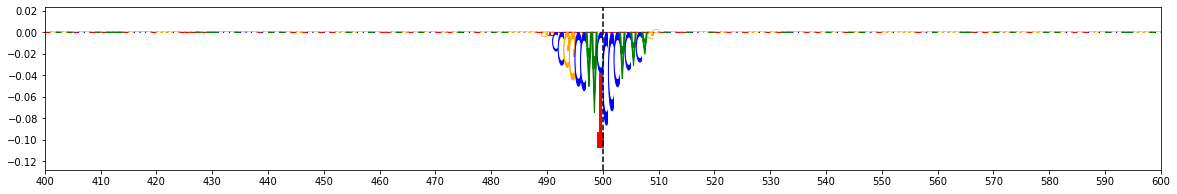



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 459

RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 78   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 1.0399E-02   ||    Coloc: False   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 0.6042   ||   Center / 200bp : 0.318

Effect Motif: CGGCTCTGGCAGAG


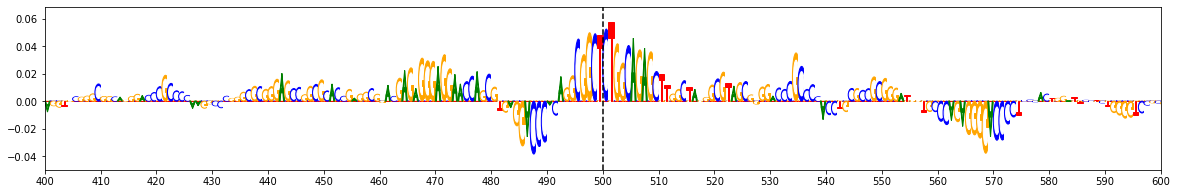

Noneffect Allele: C   ||   Noneffect Center: 0.0883   ||   Center / 200bp : 0.0928

Noneffect Motif: CGGCCCTGGCAGAG


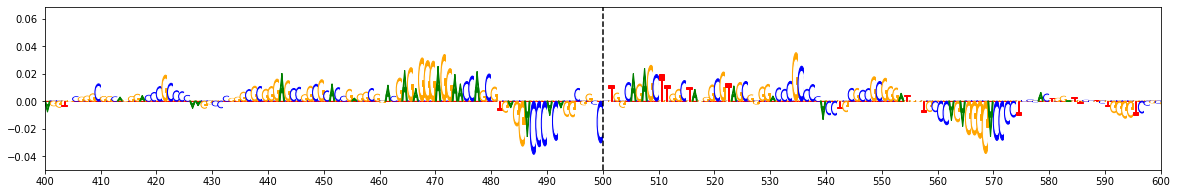

gkmExplain Score: 0.2253  ||  ISM Score: 0.9915  ||  deltaSVM Score: 5.7409

gkmExplain P-Value: 0.030314  ||  ISM P-Value: 0.032229  ||  deltaSVM P-Value: 0.036425

Difference Motif: CGGC(T/C)CTGGCAGAG


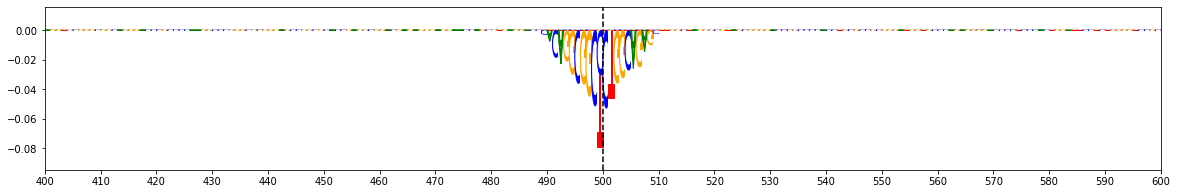



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 494

RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 93   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.7306E-03   ||    Coloc: False   ||    Confidence: 1


Effect Allele: G   ||   Effect Center: 0.2389   ||   Center / 200bp : 0.137

Effect Motif: GGGCGGAGGC


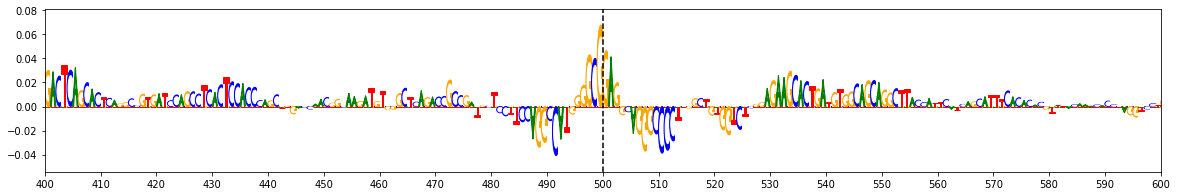

Noneffect Allele: A   ||   Noneffect Center: -0.1085   ||   Center / 200bp : 0.0

Noneffect Motif: GGGCAGAGGC


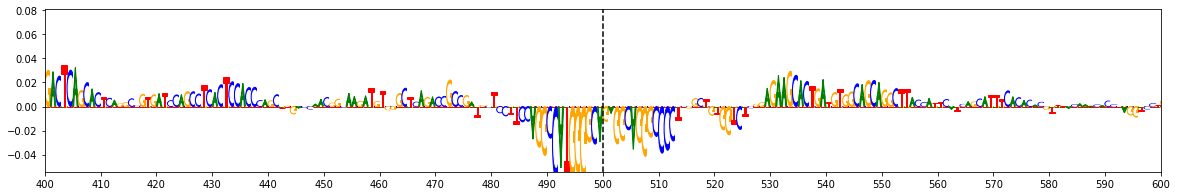

gkmExplain Score: 0.137  ||  ISM Score: 1.1933  ||  deltaSVM Score: 6.8858

gkmExplain P-Value: 0.095864  ||  ISM P-Value: 0.016803  ||  deltaSVM P-Value: 0.020059

Difference Motif: GGGC(G/A)GAGGC


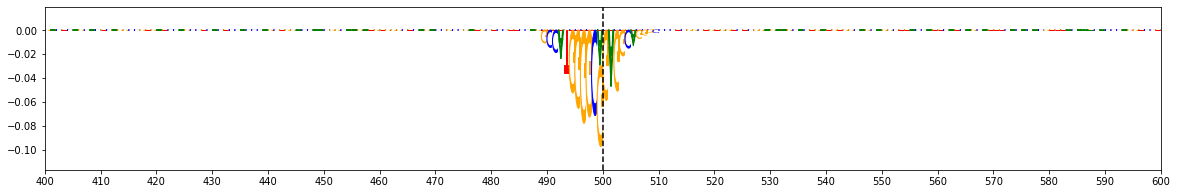



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 18

RSID: rs7900536   ||    chr10 : 80493944 - 80493945   ||    Locus: 5   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.9130E-05   ||    Coloc: True   ||    Confidence: 1


Effect Allele: A   ||   Effect Center: 1.5759   ||   Center / 200bp : 0.5702

Effect Motif: CCTCTAGAGGGATGATTCA


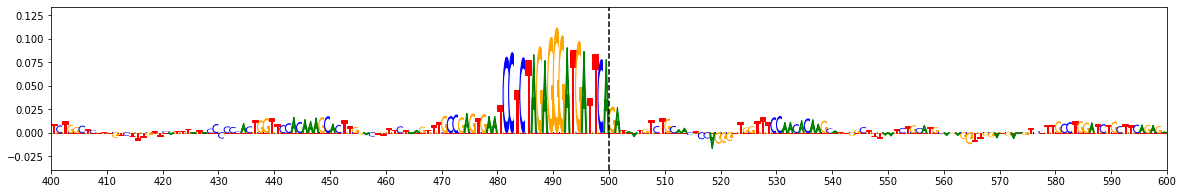

Noneffect Allele: C   ||   Noneffect Center: 1.0064   ||   Center / 200bp : 0.4752

Noneffect Motif: CCTCTAGAGGGATGATTCC


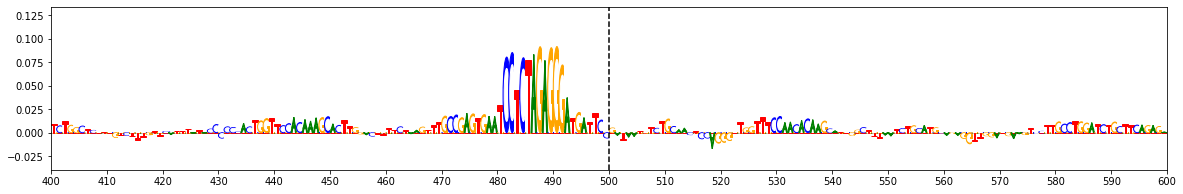

gkmExplain Score: 0.095  ||  ISM Score: 1.0202  ||  deltaSVM Score: 6.0731

gkmExplain P-Value: 0.191728  ||  ISM P-Value: 0.029275  ||  deltaSVM P-Value: 0.030456

Difference Motif: CCTCTAGAGGGATGATTC(A/C)


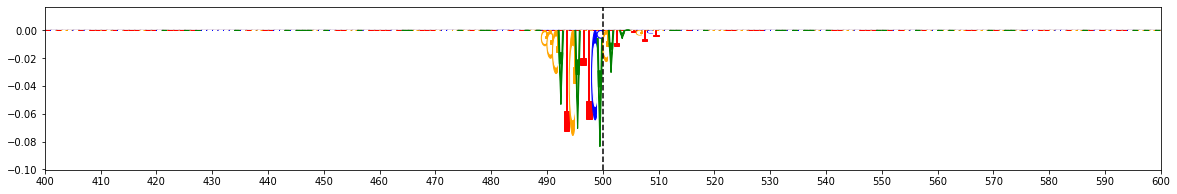



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 275

RSID: rs62063291   ||    chr17 : 45966011 - 45966012   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 2.3014E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 0.0981   ||   Center / 200bp : 0.0928

Effect Motif: CCAAGCTCCC


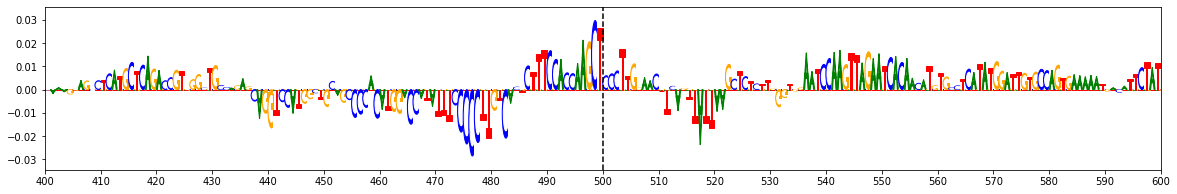

Noneffect Allele: C   ||   Noneffect Center: -0.1745   ||   Center / 200bp : 0.0

Noneffect Motif: CCAAGCCCCC


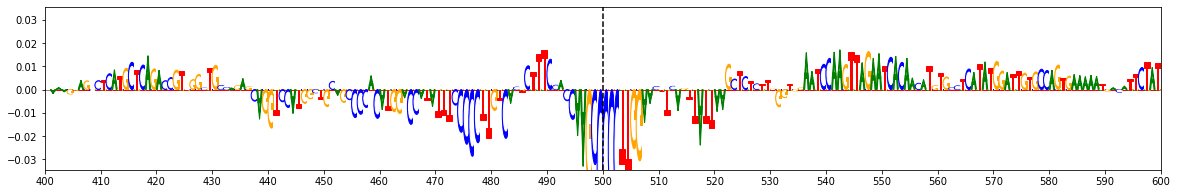

gkmExplain Score: 0.0928  ||  ISM Score: 1.159  ||  deltaSVM Score: 6.6362

gkmExplain P-Value: 0.199298  ||  ISM P-Value: 0.018695  ||  deltaSVM P-Value: 0.022735

Difference Motif: CCAAGC(T/C)CCC


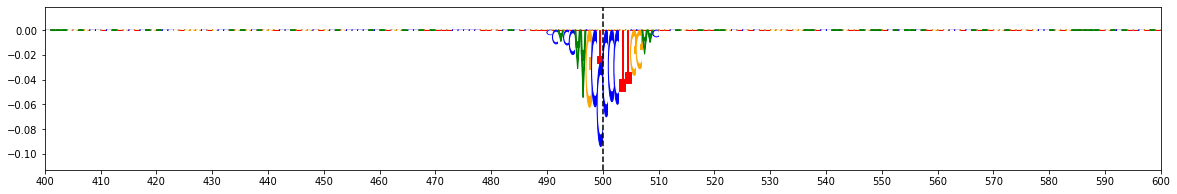



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 21

RSID: rs2296887   ||    chr10 : 102245652 - 102245653   ||    Locus: 1   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 6.9773E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.1944   ||   Center / 200bp : 0.0696

Effect Motif: ACAGGCTCCT


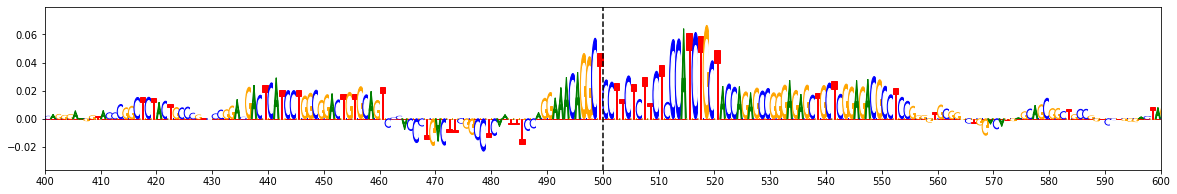

Noneffect Allele: C   ||   Noneffect Center: -0.06   ||   Center / 200bp : 0.0006

Noneffect Motif: ACAGGCCCCT


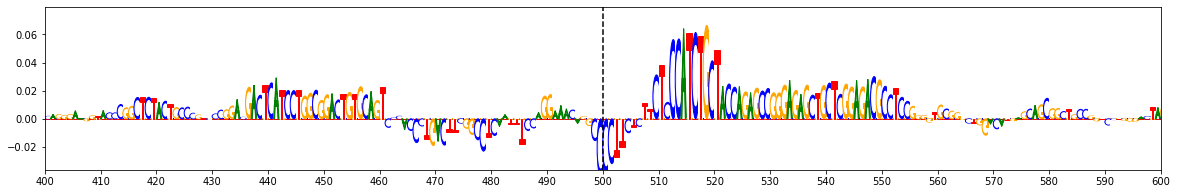

gkmExplain Score: 0.0689  ||  ISM Score: 1.0707  ||  deltaSVM Score: 6.1681

gkmExplain P-Value: 0.308049  ||  ISM P-Value: 0.024791  ||  deltaSVM P-Value: 0.028962

Difference Motif: ACAGGC(T/C)CCT


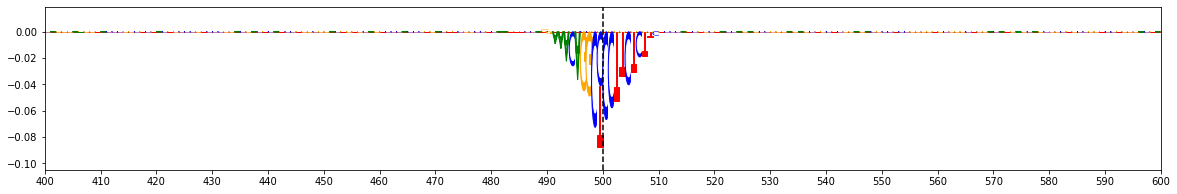



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 91

RSID: rs1140239   ||    chr16 : 30010080 - 30010081   ||    Locus: 48   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 4.4031E-03   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.1061   ||   Center / 200bp : 0.0678

Effect Motif: GCCGCTCCCG


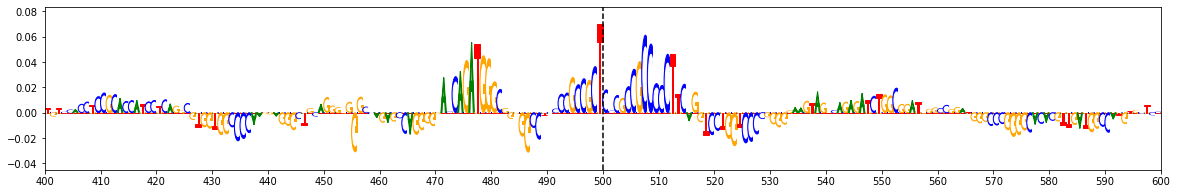

Noneffect Allele: C   ||   Noneffect Center: -0.1072   ||   Center / 200bp : 0.0

Noneffect Motif: GCCGCCCCCG


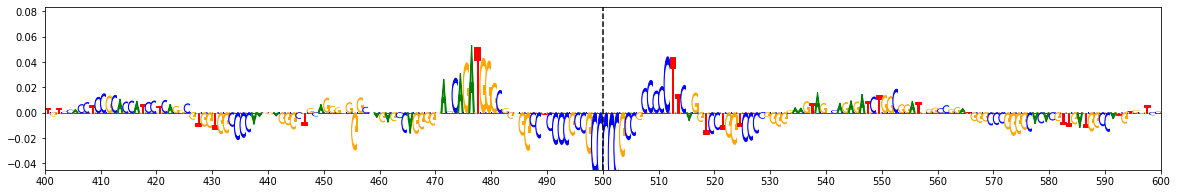

gkmExplain Score: 0.0678  ||  ISM Score: 1.5567  ||  deltaSVM Score: 9.6264

gkmExplain P-Value: 0.314686  ||  ISM P-Value: 0.005991  ||  deltaSVM P-Value: 0.005943

Difference Motif: GCCGC(T/C)CCCG


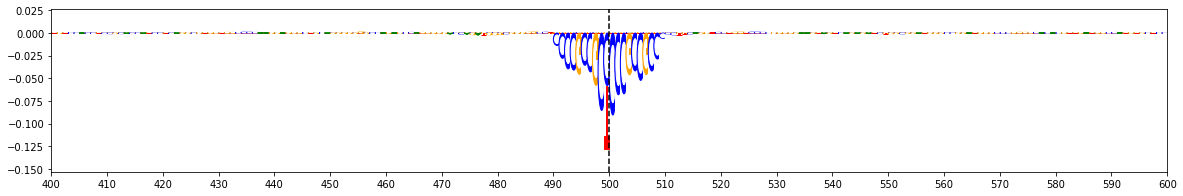



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 406

RSID: rs117612135   ||    chr19 : 45001268 - 45001269   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.1212E-46   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.1063   ||   Center / 200bp : 0.0349

Effect Motif: CCCAATCCCT


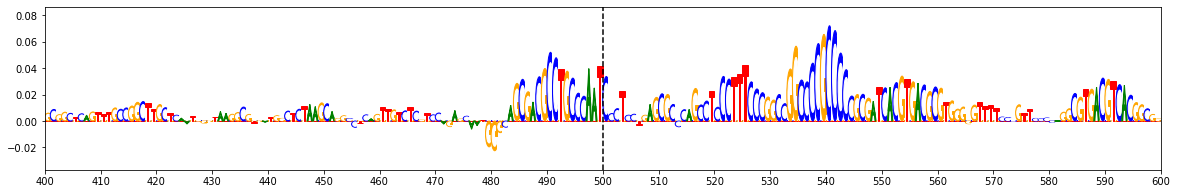

Noneffect Allele: C   ||   Noneffect Center: -0.0637   ||   Center / 200bp : 0.0

Noneffect Motif: CCCAACCCCT


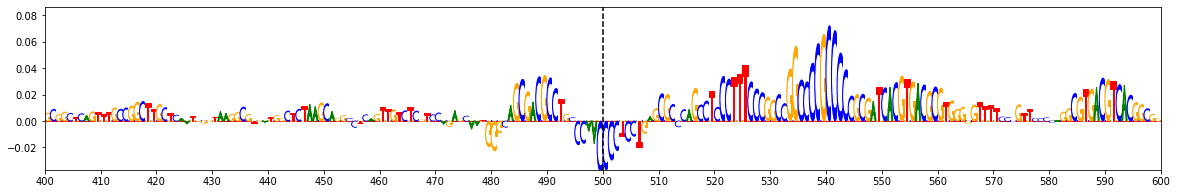

gkmExplain Score: 0.0349  ||  ISM Score: 1.0137  ||  deltaSVM Score: 5.9087

gkmExplain P-Value: 0.577723  ||  ISM P-Value: 0.029915  ||  deltaSVM P-Value: 0.033257

Difference Motif: CCCAA(T/C)CCCT


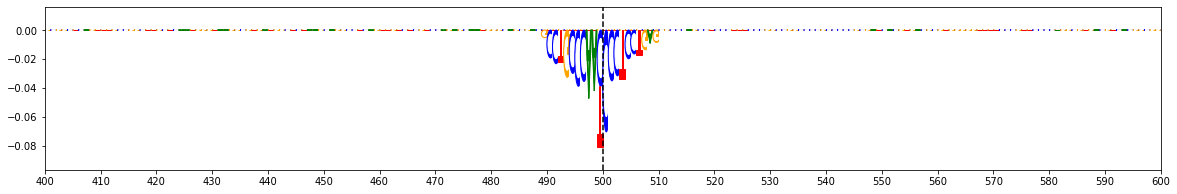



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 273

RSID: rs112003311   ||    chr17 : 45965572 - 45965573   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 2.3019E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCACGCCTGG


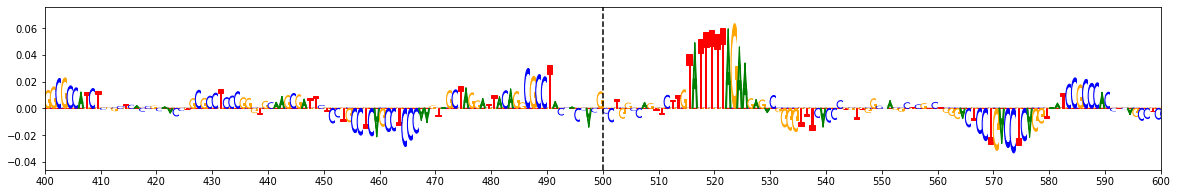

Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCACACCTGG


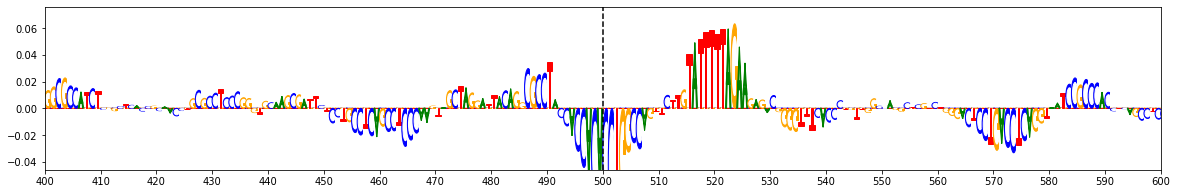

gkmExplain Score: 0.0  ||  ISM Score: 1.0914  ||  deltaSVM Score: 6.2362

gkmExplain P-Value: 0.999997  ||  ISM P-Value: 0.023177  ||  deltaSVM P-Value: 0.027944

Difference Motif: CCAC(G/A)CCTGG


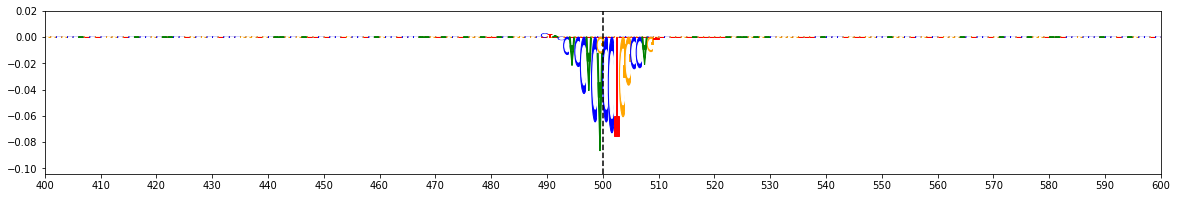



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 623

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCCTGCCGC


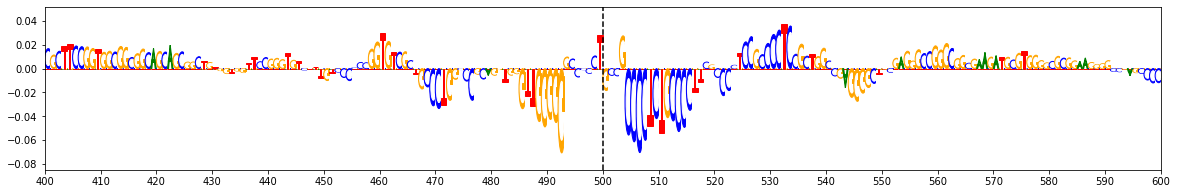

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCCGCCGC


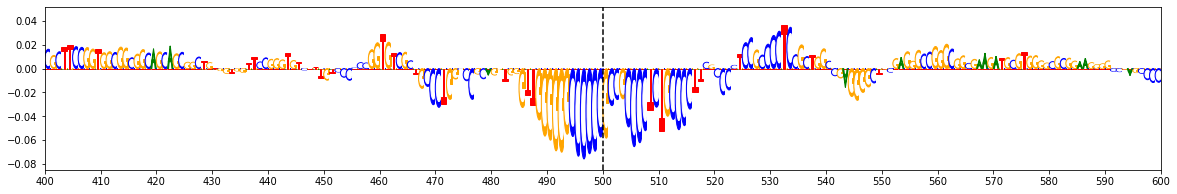

gkmExplain Score: 0.0  ||  ISM Score: 0.9879  ||  deltaSVM Score: 6.6209

gkmExplain P-Value: 0.999997  ||  ISM P-Value: 0.032625  ||  deltaSVM P-Value: 0.022913

Difference Motif: CCCC(T/C)GCCGC


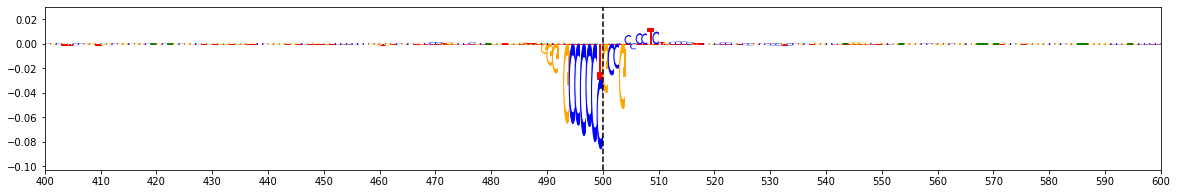



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [20]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif_other'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [21]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:6.325896501541138
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.10686373710632324
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plot

INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygeno

INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.10553193092346191
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. 

INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
I

INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:

INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.07471847534179688
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cl

INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:

INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INF

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.09763383865356445
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


# Save Significant SNPs

In [22]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [23]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
59,chr11,86103987,86103988,rs1237999,A,G,+,16,Alzheimers_Jansen_2018,7.143148e-16,False,False,0.001043,0.001603,0.006443,2,TATGAGTCACC,TAT(G/A)AGTCACC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
270,chr17,45959712,45959713,rs113793114,G,A,+,54,23andme_PD_hg38,2.581860e-22,True,False,0.023059,0.026893,0.012188,2,CAAGGAGGCGGA,CAAGGAGGC(G/A)GA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
418,chr19,45326535,45326536,rs344791,C,G,-,71,Alzheimers_Jansen_2018,1.215671e-04,True,True,0.004431,0.005977,0.020522,2,CGCCTCC,C(G/C)CCTCC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
222,chr17,45852666,45852667,rs62054825,G,A,+,54,23andme_PD_hg38,1.247000e-22,True,True,0.013624,0.016814,0.024203,2,CTCCCGGAAGTGGAG,CTCCC(G/A)GAAGTGGAG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
240,chr17,45896863,45896864,rs62056782,T,C,-,54,23andme_PD_hg38,3.938570e-22,True,True,0.006743,0.008656,0.026110,2,CGCCCTCTTGTG,CGCCCTC(T/C)TGTG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
41,chr11,60251676,60251677,rs636317,C,T,-,11,Alzheimers_Kunkle_2019,5.906000e-15,False,False,0.000131,0.000235,0.027467,2,TGCTGCCATCTGCTGGGAA,TGCTGC(C/T)ATCTGCTGGGAA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
294,chr17,46038519,46038520,rs12150090,T,C,-,54,23andme_PD_hg38,2.508350e-22,True,True,0.011933,0.014453,0.029440,2,CCAATCCCACA,CCAA(T/C)CCCACA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
459,chr2,134719288,134719289,rs62171396,T,C,-,78,Nalls_23andMe,1.039870e-02,False,True,0.032229,0.036425,0.030314,2,CGGCTCTGGCAGAG,CGGC(T/C)CTGGCAGAG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
494,chr3,52498433,52498434,rs181391313,G,A,-,93,Chang_23andMe_Parkinsons,2.730650e-03,False,True,0.016803,0.020059,0.095864,1,GGGCGGAGGC,GGGC(G/A)GAGGC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
429,chr2,95323523,95323524,rs3755519,T,A,+,85,Nalls_23andMe,7.682450e-03,False,True,0.011536,0.014240,0.146132,1,AGTGCTCTCTG,(A/T)GTGCTCTCTG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
